In [26]:
using Plots, PlotThemes, LaTeXStrings
using OffsetArrays
using LinearAlgebra
using FFTW
using StatsBase
using Unitful
using Base: Fix1, Fix2
using Distributions

gr()

theme(:juno)
default(;palette=:seaborn_pastel6, background_color="#1b3041", fontfamily="serif")
j=im

im

In [27]:
S = OffsetArray(sqrt(13/6).*[0, 0, 1+j, 0, 0, 0, -1-j, 0, 0, 0, 1+j, 0, 0, 0, -1-j, 0, 0, 0, -1-j, 0, 0, 0, 1+j, 0, 0, 0, 0,
0, 0, 0, -1-j, 0, 0, 0, -1-j, 0, 0, 0, 1+j, 0, 0, 0, 1+j, 0, 0, 0, 1+j, 0, 0, 0, 1+j, 0,0], -26:26)

shift(x) = [i in 1:26 ? x[i] : (i in 38:63 ? x[i-64] : 0.0+im*0.0) for i in 0:63]

function shift(x, ifft_points)
    x_shift = vcat(x[0:26], zeros(ifft_points-53), x[-26:-1])
    return x_shift
end

function make_preamble(sym) 
    sym2 = sym[length(sym)-Int(length(sym)/2)+1:end]
    return vcat(sym2, sym, sym)
end

function freq_to_wave(x, ifft_points)
    return shift(x, ifft_points) |> ifft |> make_preamble
end

freq_to_wave (generic function with 1 method)

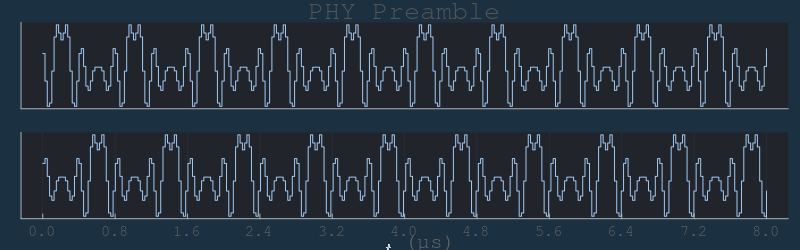

In [28]:
N = 128
sym = freq_to_wave(S, N)
t = range(0u"μs", 8u"μs", length=length(sym))
tiks = [0:0.8:8...]
p2 = plot(t, imag(sym), yticks=false, line=:steppost, ylabel="canal I", xlabel=L"t", xticks = tiks, title="")
p1 = plot(t, real(sym), yticks=false, line=:steppost, ylabel="canal Q", xlabel="", xticks=[], title="PHY Preamble")

plot(p1, p2, layout=(2,1), legend = false, size=(800,250), background_color="#1b3041")

In [29]:
range(1,2, )

1:2

In [30]:
Δf = 1e3
Ts = 8e-6
Nf = 7
ref = sym

fs = range(-Δf/2, Δf/2, length=Nf)


refs = hcat([exp.(2π*j*Ts*f.*ns).*ref for f in fs]...)
hcat([x1'*r for r in eachcol(refs)]...)

UndefVarError: UndefVarError: `ns` not defined

In [31]:
function short_correlate(y, idx, ref, Ts, Δf, Nf)
    x1 = y[idx:idx+length(ref)-1]
    ns = 0:length(ref)-1
    fs = range(-Δf/2, Δf/2, length=Nf)
    refs = hcat([exp.(2π*j*Ts*f.*ns).*ref for f in fs]...)
    return hcat([x1'*r for r in eachcol(refs)]...)
end



short_correlate (generic function with 1 method)

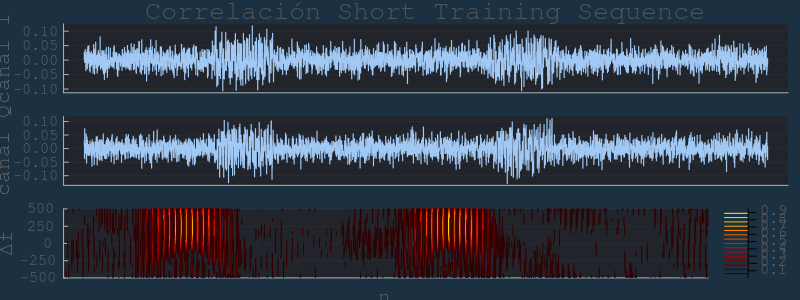

In [32]:
f_err = 0.25e3


N = 4000
start_t1 = 700
start_t2 = 2200


σ=0.025
d = Normal(0,σ)
sym_ferr = sym.*exp.(im*2*pi*f_err*Ts.* (1:length(sym)))

y = rand(d, N) .+ j.*rand(d, N)
y[start_t1+1:start_t1+length(sym)] .+= sym_ferr
y[start_t2+1:start_t2+length(sym)] .+= sym_ferr


idxs = 1:N-length(sym)
est1 = vcat([short_correlate(y, idx, ref, Ts, Δf, Nf) for idx in idxs]...)

p1 = plot(real(y[idxs]), xticks=false, line=:steppost, ylabel="canal I", xlabel="", title="Correlación Short Training Sequence")
p2 = plot(imag(y[idxs]), xticks=false, line=:steppost, ylabel="canal Q", xlabel="")
p3 = heatmap(idxs, fs, abs.(est1)', line=:steppost, ylabel="Δf", xlabel="n", xticks=[])

plot(p1, p2, p3, layout=(3,1), legend = false, size=(800,300), background_color="#1b3041")

In [33]:
function threshold(PFA, σ2, ref)
    return sqrt(-2*norm(ref)^2*σ2*log(PFA))
end


function estimate_noise(y, idx, N)
    y1 = y[idx:idx+N-1]
    y_m = mean(y1)
    return (norm(y1.-y_m))^2/(2*(N-1))
end


estimate_noise (generic function with 1 method)

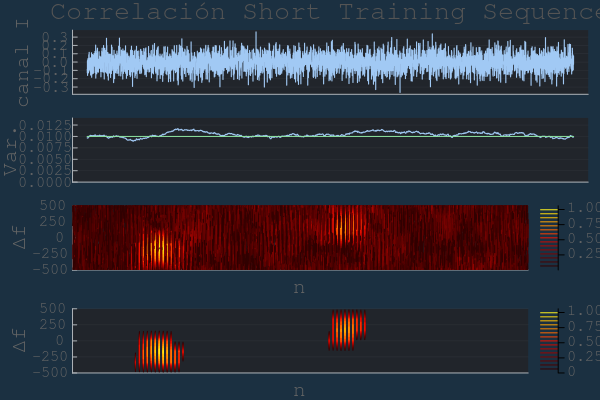

In [34]:
N = 4000
start_t1 = 700
start_t2 = 2200

σ=0.1
d = Normal(0,σ)

y = rand(d, N) .+ j.*rand(d, N)
f_err = -0.2e3
sym_ferr = sym.*exp.(im*2*pi*f_err*Ts.* (1:length(sym)))
y[start_t1+1:start_t1+length(sym)] .+= sym_ferr
f_err = 0.15e3
sym_ferr = sym.*exp.(im*2*pi*f_err*Ts.* (1:length(sym)))
y[start_t2+1:start_t2+length(sym)] .+= sym_ferr

L = length(sym)
idxs = 1:N-L
est1 = vcat([short_correlate(y, idx, ref, Ts, Δf, Nf) for idx in idxs]...)

PFA = 10e-6
est_var = [estimate_noise(y, i, L) for i in idxs]
Ths = [threshold(PFA, v, sym) for v in est_var]

true_var = idxs.*0 .+ σ^2

detect(est, Ts) = abs(est) > Ts
row_detect(est_row, T) = [detect(est, T) ? est : 0 for est in est_row]
detections = hcat([row_detect(est_row, T) for (est_row, T) in zip(eachrow(abs.(est1)), Ths)]...)

p1 = plot(real(y[idxs]), xticks=false, line=:steppost, ylabel="canal I", xlabel="", title="Correlación Short Training Sequence")
p2 = plot(est_var, line=:steppost, ylabel="Var.", xlabel="", xticks=[], label="MVU")
plot!(p2, true_var, label="σ²", ylims=(0, maximum(est_var)*1.2))
p3 = heatmap(idxs, fs, abs.(est1)', line=:steppost, ylabel="Δf", xlabel="n", xticks=[])
p4 = heatmap(idxs, fs, detections, line=:steppost, ylabel="Δf", xlabel="n", xticks=[])

plot(p1, p2, p3, p4, layout=(4,1), legend = false, background_color="#1b3041")

┌ Info: (0.0, 1.0620344138192652)
└ @ Main /home/inox/Documents/IB/Proyecto Integrador/banco_xcorr.ipynb:4


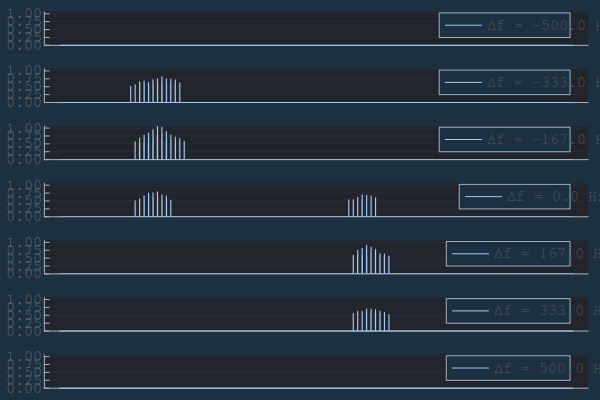

In [39]:
p = repeat([plot()], length(fs))

ylims = extrema(detections)
@info ylims

for i in 1:length(fs)
    p[i] = plot(idxs, detections[i,:], line=:steppost, xticks=[], ylims=ylims, label="Δf = $(round(fs[i])) Hz")
end

plot(p..., layout=(length(fs),1), background_color="#1b3041")